#**1. Import Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import datasets, transforms
import pprint
from sklearn.impute import SimpleImputer
import wandb




In [ ]:
print("PyTorch Version: ", torch.__version__)

PyTorch Version:  2.5.1+cu124


#**2. Loading and Understanding Data**

**Download dataset from kaggle**

In [ ]:
# Load dataset from Kaggle
path = kagglehub.dataset_download("himelsarder/road-accident-survival-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.19k/1.19k [00:00<00:00, 2.65MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/himelsarder/road-accident-survival-dataset/versions/1


**File Path**

In [ ]:
file_path=os.path.join(path, 'accident.csv')

**Displaying Dataset**

In [ ]:
my_dataframe = pd.read_csv(file_path)
my_dataframe.head(10)

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0
5,25,Male,49.0,Yes,Yes,1
6,38,Male,116.0,Yes,Yes,1
7,56,Male,47.0,Yes,Yes,1
8,36,Female,83.0,Yes,No,1
9,40,Female,116.0,Yes,No,1


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=my_dataframe)

https://docs.google.com/spreadsheets/d/14V1t-o0HadcmkTdiCzDXdKUgW5cUkCv07gMEAlrrK50#gid=0


In [ ]:
my_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [ ]:
desired_df = my_dataframe[['Age', 'Speed_of_Impact', 'Survived']].copy()
desired_df.fillna(desired_df.mean(), inplace=True)
desired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Speed_of_Impact  200 non-null    float64
 2   Survived         200 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 4.8 KB


#**3. Data Preprocessing**

**Handle missing values**

In [ ]:
# Handle missing values using mean imputation for numerical features and Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Assuming you want to impute on the 'my_dataframe' DataFrame
df = my_dataframe.copy()

# Impute missing values in numerical columns
numerical_cols = ['Age', 'Speed_of_Impact']
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

**Encoding Categorical Variables**

In [ ]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56.0,0,27.0,0,0,1
1,69.0,0,46.0,0,1,1
2,46.0,1,46.0,1,1,0
3,32.0,1,117.0,0,1,0
4,60.0,0,40.0,1,1,0


In [ ]:
feature_columns = ['Age', 'Speed_of_Impact']
label_column = ['Survived']

# Extract features and label
features = desired_df[feature_columns].values
labels = desired_df[label_column].values

**Feature Scaling**

In [ ]:
# Used StandardScaler because my dataset has features with different ranges so a standardScaler helps in normalising them and improving gradient descent optimization.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

**Splitting Data into Training and Testing Sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

**Converting to PyTorch Tensors**

In [ ]:
# Convert scaled data and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

**Correlation Matrix**

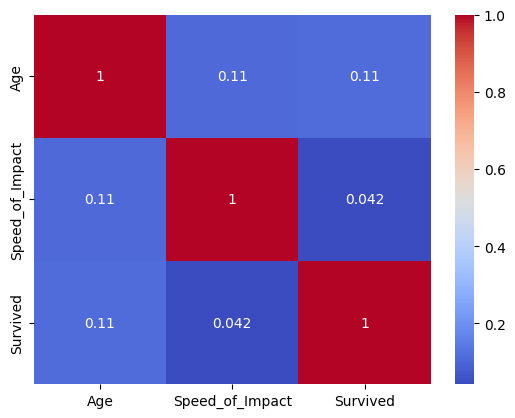

In [ ]:
# Create heatmap of correlations, but only for numeric columns
sns.heatmap(desired_df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.show()

#**4. Model Definition/Initialisation**

In [ ]:
# Define Multi-Class Classification Model using nn.Sequential
num_classes = len(np.unique(y_train))
input_size = X_train.shape[1]

In [ ]:
# I used CrossEntropy Loss criterion because it is appropriate for a multiclass classification
criterion = nn.CrossEntropyLoss()

model = nn.Sequential(
    nn.Linear(input_size, 64),  # Input Layer with 64 neurons
    nn.ReLU(),
    nn.Dropout(0.2),  # Dropout layer to prevent overfitting
    nn.Linear(64, 32),  # 2 Hidden Layer
    nn.ReLU(),
    nn.Linear(32, num_classes),  # Output Layer with 32 neurons
    nn.Softmax(dim=1)  # Softmax activation
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

#**5. Setting Up Hyperparameter Tuning with WANDBS**

In [ ]:
!pip install wandb -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 86.4 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lullobuso (lullobuso-cortex-hub) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

**Sweep Configuration**

In [ ]:
sweep_config = {
    'method': 'random',
}

metric = {
    'name': 'loss',
    'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'fc_layer_size': {
        'values': [8, 16, 32, 64]
        },
    'dropout': {
          'values': [0.2, 0.3, 0.4, 0.5, 0.6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 50}
    })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0.2 and 0.6
        'distribution': 'uniform',
        'min': 0.2,
        'max': 0.6
      },
    'batch_size': {
        # integers between 8 and 64
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 8,
        'max': 64,
      }
    })

sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: zhn1jm4c
Sweep URL: https://wandb.ai/lullobuso-cortex-hub/pytorch-sweeps-demo/sweeps/zhn1jm4c


In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 64,
                               'min': 8,
                               'q': 8},
                'dropout': {'values': [0.2, 0.3, 0.4, 0.5, 0.6]},
                'epochs': {'value': 50},
                'fc_layer_size': {'values': [4, 8, 16, 32, 64]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.6,
                                  'min': 0.2},
                'optimizer': {'values': ['adam']}}}


#**6. Model Building**

**Setting Up Device**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize Weights and Biases Sweep
sweep_id = wandb.sweep(sweep_config, project="road-accident-survival")

def build_dataset(batch_size):
    # This function should return the appropriate dataset loader
    pass

Create sweep with ID: peqphksw
Sweep URL: https://wandb.ai/lullobuso-cortex-hub/road-accident-survival/sweeps/peqphksw


**Building the Deep Neural Network**

In [ ]:
# Building the Deep Neural Network
def build_network(fc_layer_size, dropout):
    return nn.Sequential(
        nn.Linear(X_train.shape[1], fc_layer_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 32),
        nn.ReLU(),
        nn.Linear(32, len(np.unique(y_train))),
        nn.Softmax(dim=1)
    ).to(device)

#**7. Defining the Optimizer**

In [ ]:
# Choosed Adam as an optimizer based on W&B tuning
def build_optimizer(network, optimizer_name, learning_rate):
    if optimizer_name == 'adam':
        return optim.Adam(network.parameters(), lr=learning_rate)

#**8. Training Function**

In [ ]:
def train_epoch(network, loader, optimizer):
    # This function should implement one epoch of training and return the average loss
    pass

def train(config=None): # Fixed: Indentation
    with wandb.init(config=config):
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})

#**9. Running the Hyperparameter Tuning**

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: ikad1ezb with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.28234584015936165
wandb: 	optimizer: adam
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: 9ya9dxtp with config:
wandb: 	batch_size: 8
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	fc_layer_size: 8
wandb: 	learning_rate: 0.3580994804961802
wandb: 	optimizer: adam


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: htp7n2z1 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.3481538092280535
wandb: 	optimizer: adam


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch,49


wandb: Agent Starting Run: t2q2hz7z with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.5
wandb: 	epochs: 50
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.4749552534845056
wandb: 	optimizer: adam


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,49


wandb: Agent Starting Run: 2b9o9vdb with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	fc_layer_size: 4
wandb: 	learning_rate: 0.27153061972212666
wandb: 	optimizer: adam


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,49


#**10. Final Model Training**

In [ ]:
#Hyperparameters
learning_rate = 0.5186959411523272
batch_size = 24
num_epochs = 50
fc_layer_size = 32
dropout = 0.3
optimizer_name = 'adam'

In [ ]:
# Training Loop
num_epochs = 50 #I used 50 epochs to allow for a sufficient training time and avoiding overfitting
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    # Forward Pass
    outputs = model(X_train_tensor)

    # Reshape y_train_tensor to 1D
    y_train_tensor_1d = y_train_tensor.squeeze()

    # Calculate loss using reshaped target tensor
    loss = criterion(outputs, y_train_tensor_1d.long())

    # Backward Pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)

        # Reshape y_test_tensor to 1D for evaluation
        y_test_tensor_1d = y_test_tensor.squeeze()

        test_loss = criterion(test_outputs, y_test_tensor_1d.long()) # Use reshaped tensor

    # Store losses
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/50], Train Loss: 0.6826, Test Loss: 0.6877
Epoch [20/50], Train Loss: 0.6803, Test Loss: 0.6864
Epoch [30/50], Train Loss: 0.6786, Test Loss: 0.6999
Epoch [40/50], Train Loss: 0.6785, Test Loss: 0.6921
Epoch [50/50], Train Loss: 0.6732, Test Loss: 0.6950


**Plotting Training History**

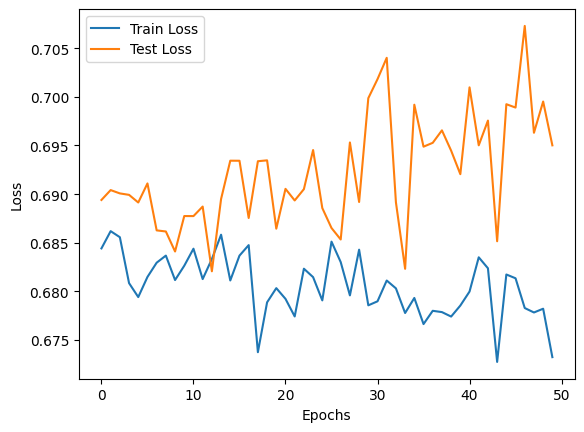

In [ ]:
# Plot Training History
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**11. Model Evaluation**

In [ ]:
# Model Evaluation
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_tensor, axis=1).numpy()

In [ ]:
# Calculating Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5250


**Classification Report**

In [ ]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.55      0.54        20
           1       0.53      0.50      0.51        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



#**Rererences**

1. Kagglehub
2. ChatGPT
3. Cortex Hub AI & ML Study material compiled by Luthando Maqondo.
4. Google Gemini
5. WANDBS



